In [4]:
from SSMTools import *
import numpy as np
import pandas as pd
from Utilities import *
from ModelTest import loadTestSets

In [5]:
colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

### Testing augmented state space model

In [6]:
df_beartrap = pd.read_csv("../raw_data/csv-1/Bear_Trap_snowon.csv").drop(["datetime"], axis=1)

#### Single sensor

In [7]:
nLF = 1

ti = 500 #7850
tf = 900 #8000

sensor = 0

Y, cs, ci = alignSeries(df_beartrap.values.T[sensor:(sensor+1), ti:tf])
N, T = Y.shape

# Run EM
XHat, sigma_smooth, A, C, Q, R, pi0, sigma0 = ssmEMAug(Y, nLF, maxIt=500)

# Estimate observations
YHat = np.dot(C, XHat)

# Descale
YHatDS = (YHat.copy() - ci[0]) / cs[0]

# Compute likelihood
logLs = logL(XHat, Y, pi0, sigma0, A, C, Q, R)

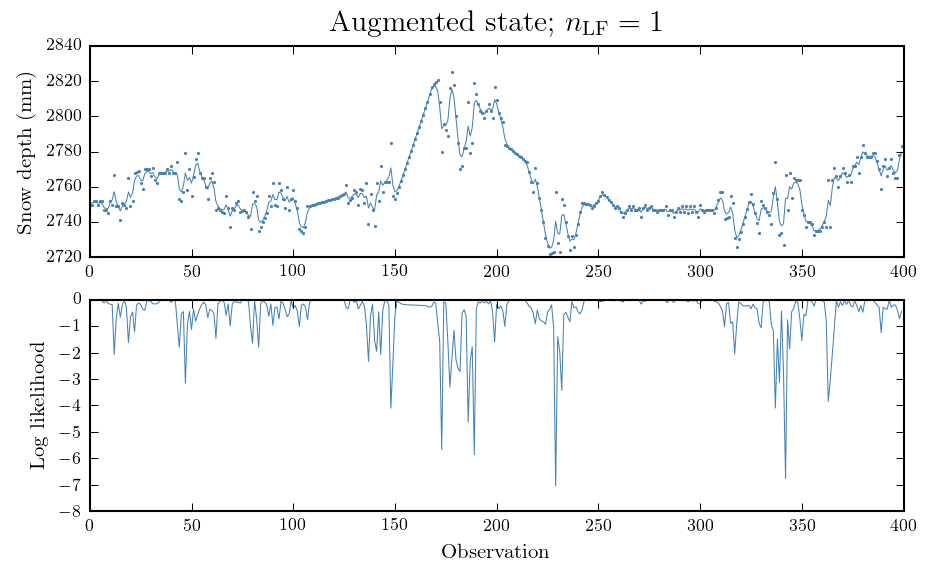

In [9]:
plt.figure(figsize=(7, 4))
c = colors[0]

plt.subplot(2, 1, 1)
plt.title(r"Augmented state; $n_{\rm LF} = %i$"%nLF)

# Plot smoothed observations and data
plt.plot(range(tf-ti), df_beartrap[df_beartrap.columns[sensor]][ti:tf], '.', color=c, markersize=2)
plt.plot(YHatDS.T, color=c, linewidth=0.5)

plt.xlim(0, tf-ti)
plt.ylabel("Snow depth (mm)")

# Plot likelihood
plt.subplot(2, 1, 2)
plt.plot(logLs, linewidth=0.5)
plt.xlim(0, tf-ti)
plt.xlabel("Observation")
plt.ylabel("Log likelihood")

#### Multiple sensors

In [10]:
nLF = 1

ti = 600 #7850
tf = 750 #8000

Y, cs, ci = alignSeries(df_beartrap.values.T[:, ti:tf])
N, T = Y.shape

# Run EM
XHat, sigma_smooth, A, C, Q, R, pi0, sigma0 = ssmEMAug(Y, nLF, maxIt=500)

# Estimate observations
YHat = np.dot(C, XHat)

# Descale
YHatDS = YHat.copy()
for s in range(N):
    YHatDS[s, :] = (YHatDS[s, :] - ci[s]) / cs[s]
    
logLs = logL(XHat, Y, pi0, sigma0, A, C, Q, R)

(0, 150)

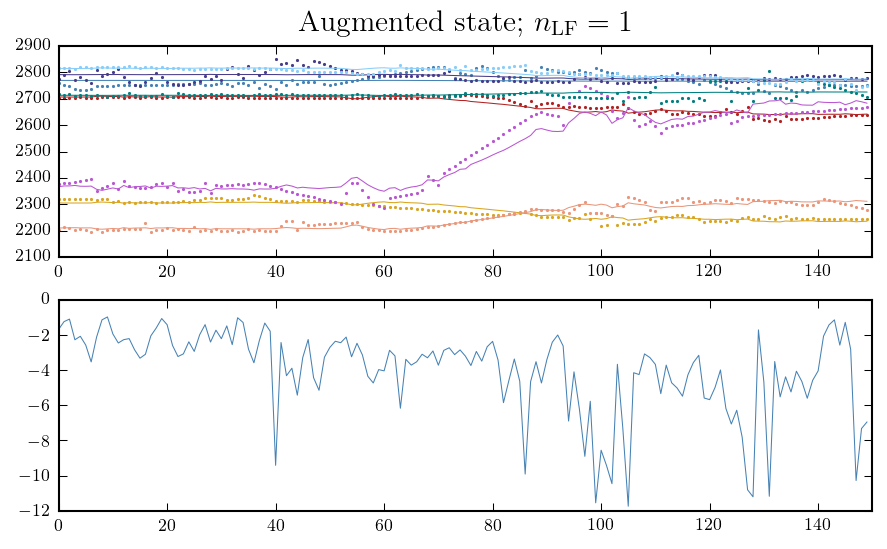

In [11]:
plt.figure(figsize=(7, 4))

plt.subplot(2, 1, 1)

plt.title(r"Augmented state; $n_{\rm LF} = %i$"%nLF)

for i, (s, c) in enumerate(zip(df_beartrap.columns, colors)):
    plt.plot(range(tf-ti), df_beartrap[s][ti:tf], '.', color=c, markersize=2)
    plt.plot(YHatDS[i, :], color=c, linewidth=0.5)

plt.xlim(0, tf-ti)

plt.subplot(2, 1, 2)
plt.plot(logLs, linewidth=0.5)
plt.xlim(0, tf-ti)

In [16]:
import subprocess
subprocess.call(["echo", "\a"])

0

## Full dataset with temperatures

In [12]:
df_cleaned = loadAndClean("../output/site_1_cleaned_T.csv", toDrop=['snowdepth_2', 'snowdepth_10', 'Unnamed: 0', 'Unnamed: 0.1', 'datetime'])
for i in range(1, 11):
    df_cleaned.drop('temperature_%i'%i, axis=1, inplace=True)
fullData = df_cleaned.values

In [13]:
df_temp = pd.read_csv("../output/site_1_cleaned_T.csv").drop(['temperature_2', 'temperature_10', 'Unnamed: 0', 'Unnamed: 0.1', 'datetime'], axis=1)
for i in range(1, 11):
    df_temp.drop('snowdepth_%i'%i, axis=1, inplace=True)
tempData = df_temp.values

In [14]:
dateTimes = pd.read_csv("../output/site_1_cleaned_T.csv").drop(['Unnamed: 0', 'Unnamed: 0.1']
                                                               + ["snowdepth_%i"%i for i in range(1, 11)]
                                                               + ["temperature_%i"%i for i in range(1, 11)], axis=1).values.flatten()

### See how likelihood correlates with jumps

In [15]:
ti = 10550 #7850
tf = 10750 #8000

In [16]:
YRaw = fullData[ti:tf, :].T
XHat_MS, sigma_smooth_MS, A_MS, C_MS, Q_MS, R_MS, pi0_MS, sigma0_MS = ssmEM(YRaw, 7, maxIt=100)
YHat_MS = np.dot(C_MS, XHat_MS)

In [17]:
logLs = logL(XHat_MS, YRaw, pi0_MS, sigma0_MS, A_MS, C_MS, Q_MS, R_MS)

([<matplotlib.axis.XTick at 0x112b9d1d0>,
 <a list of 4 Text xticklabel objects>)

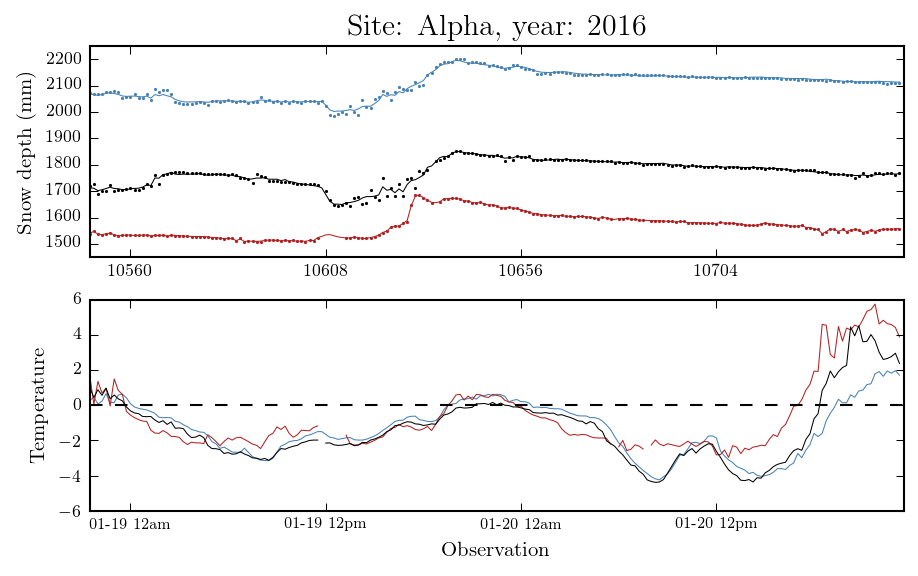

In [18]:
plt.figure(figsize=(7, 4))

sensor_of_interest = 4
sensors_to_plot = [1, 7] + [sensor_of_interest]
########
plt.subplot(2, 1, 1)

for s, c in zip(sensors_to_plot, colors):
    if s == sensor_of_interest:
        col = 'black'
    else:
        col = c
    plt.plot(range(ti, tf), YRaw[s, :], '.', color=col, markersize=2)
    plt.plot(range(ti, tf), YHat_MS[s, :], color=col, linewidth=0.5)

plt.xlim(ti, tf)
plt.ylim(1450, 2250)
plt.title("Site: Alpha, year: 2016")
# Ticks at midnight and noon
xticks, xlabels = getMidnightNoonIdx(dateTimes, ti, tf)
plt.xticks(xticks)
plt.ylabel("Snow depth (mm)")
########
plt.subplot(2, 1, 2)
for s, c in zip(sensors_to_plot, colors):
    if s == sensor_of_interest:
        col = 'black'
    else:
        col = c
    plt.plot(range(ti, tf), tempData[ti:tf, s], color=col, linewidth=0.5)

plt.plot([ti, tf], [0, 0], '--k')
plt.xlim(ti, tf)
plt.ylabel("Temperature")
########
#plt.subplot(3, 1, 3)
#plt.plot(range(ti, tf), logLs, linewidth=0.5)

#plt.ylabel("Log likelihood")

plt.xlabel("Observation")
plt.xlim(ti, tf)
plt.xticks(xticks, xlabels, fontsize=7)

#### See about detecting jumps with the likelihood

In [178]:
df_beartrap = pd.read_csv("../raw_data/csv-1/Bear_Trap_snowon.csv").drop(["datetime"], axis=1)

In [74]:
nLF = 3

ti = 600 #7850
tf = 750 #8000

Y, cs, ci = alignSeries(df_beartrap.values.T[:, ti:tf])
N, T = Y.shape

# Run EM
XHat, sigma_smooth, A, C, Q, R, pi0, sigma0 = ssmEM(Y, nLF, maxIt=50)

# Estimate observations
YHat = np.dot(C, XHat)

# Descale
YHatDS = YHat.copy()
for s in range(N):
    YHatDS[s, :] = (YHatDS[s, :] - ci[s]) / cs[s]

In [75]:
logLs = logL(XHat, Y, pi0, sigma0, A, C, Q, R)

(0, 150)

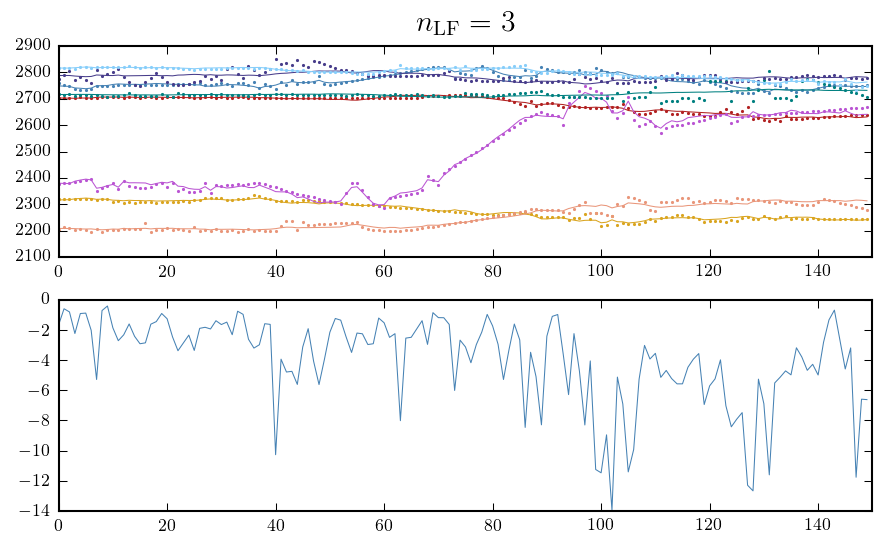

In [76]:
plt.figure(figsize=(7, 4))

plt.subplot(2, 1, 1)

plt.title(r"$n_{\rm LF} = %i$"%nLF)

for i, (s, c) in enumerate(zip(df_beartrap.columns, colors)):
    plt.plot(range(tf-ti), df_beartrap[s][ti:tf], '.', color=c, markersize=2)
    plt.plot(YHatDS[i, :], color=c, linewidth=0.5)

plt.xlim(0, tf-ti)

plt.subplot(2, 1, 2)
plt.plot(logLs, linewidth=0.5)
plt.xlim(0, tf-ti)

In [209]:
import subprocess
subprocess.call(["echo", "\a"])

0

### Run EM on datasets with points artificially removed

In [172]:
nLF = 3

testSets = loadTestSets(fullData=fullData, dirName="test_data/intervalLen_300/")
testSet = testSets[2]
ti = testSet["ti"]
tf = ti + testSet["intervalLen"]
sensor = testSet["sensor"]

Y, cs, ci = alignSeries(testSet["data"].T[:, ti:tf])
YFull, csFull, ciFull = alignSeries(testSet["fullData"].T[:, ti:tf])
#Y = testSet["fullData"].T[:, ti:tf].copy()

N, T = Y.shape

In [163]:
YMD = testSet["fullData"].T[:, ti:tf].copy()
YMD[5:6, 90:170] = np.nan
Y, cs, ci = alignSeries(YMD)

In [173]:
XHat, sigma_smooth, A, C, Q, R, pi0, sigma0 = ssmEM(Y, nLF, maxIt=500)

# Estimate observations
YHat = np.dot(C, XHat)

In [157]:
XHatFull, _, _, CFull, _, _, _, _ = ssmEM(YFull, nLF, maxIt=500)

# Estimate observations
YHatFull = np.dot(CFull, XHatFull)

In [174]:
# Descale
YHatDS = YHat.copy()
YHatDSFull = YHatFull.copy()

for s in range(N):
    YHatDSFull[s, :] = (YHatDSFull[s, :] - ciFull[s]) / csFull[s]
    YHatDS[s, :] = (YHatDS[s, :] - ci[s]) / cs[s]

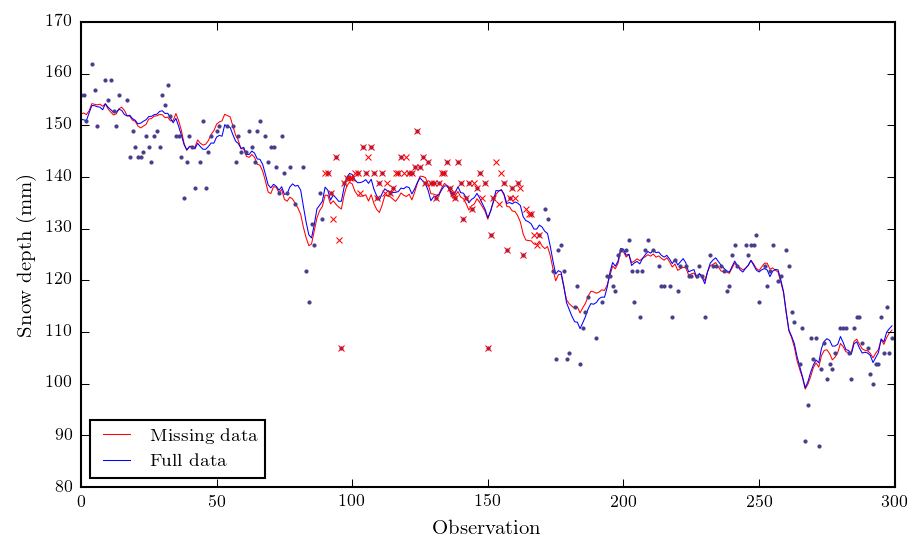

In [175]:
plt.figure(figsize=(7, 4))

sensor = testSet["sensor"]

# Missing data result
plt.plot(YHatDS[sensor, :], color='r', linewidth=0.5, label="Missing data")
# Full data result
plt.plot(YHatDSFull[sensor, :], color="b", linewidth=0.5, label="Full data")
    
# Mark points that were artificially removed
plt.plot(testSet["data"][ti:tf, sensor], '.', color=colors[sensor], markersize=3)
#plt.plot(testSet["removedTimes"] - ti, testSet["fullData"][testSet["removedTimes"], sensor], 'x', color='r', markersize=3)
plt.plot(range(90, 170), testSet["fullData"][[ti + t for t in range(90, 170)], 5:6], 'x', color='r', markersize=3)

#plt.ylim(1890, 2070)
plt.xlabel("Observation")
plt.ylabel("Snow depth (mm)")
plt.xlim(0, tf-ti)

plt.legend(loc="lower left")

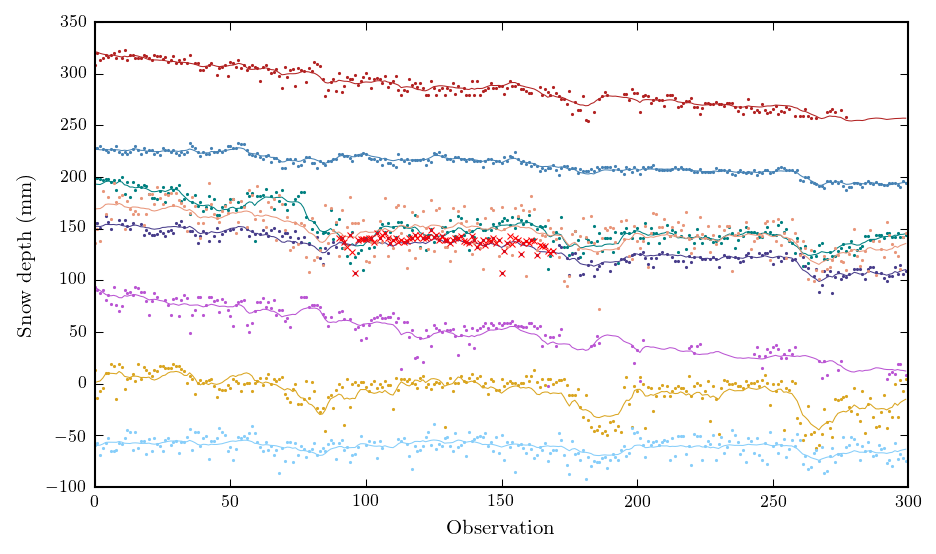

In [177]:
plt.figure(figsize=(7, 4))

for s, c in zip(range(N), colors):
    plt.plot(testSet["data"][ti:tf, s], '.', color=c, markersize=2)
    plt.plot(YHatDS[s, :], color=c, linewidth=0.5)

# Mark points that were artificially removed
#plt.plot(testSet["removedTimes"] - ti, testSet["fullData"][testSet["removedTimes"], sensor], 'x', color='r', markersize=2)
plt.plot(range(90, 170), testSet["fullData"][[ti + t for t in range(90, 170)], 5:6], 'x', color='r', markersize=3)

plt.xlim(0, tf-ti)

plt.xlabel("Observation")
plt.ylabel("Snow depth (mm)")

In [97]:
import subprocess
subprocess.call(["echo", "\a"])

0

## Check how learned parameters change with time

In [170]:
nLF = 3

ti = 5000
tf = 5100

Y = fullData[ti:tf, 0:fullData.shape[1]/2].T

N, T = Y.shape

XHat5000, sigma_smooth5000, A5000, C5000, Q5000, R5000, pi05000, sigma05000 = ssmEM(Y, nLF, maxIt=500)

print "A5000 = " + str(A5000)
print "C5000 = " + str(C5000)

A5000 = [[ 1.57783232 -1.13131494 -0.39066024]
 [ 1.08198078 -0.69328231 -0.52959206]
 [-2.14985369  3.24820645  1.99701254]]
C5000 = [[-0.57475091  2.55980166  1.13367975]
 [-0.75343982  3.37990617  1.49865346]
 [ 0.02476291  0.02572308  0.01689129]
 [-0.15824867  0.69647566  0.30470077]
 [-0.39020584  1.7589791   0.78015277]
 [-0.3482021   1.62909635  0.72502675]
 [-0.38420461  1.72867116  0.76671167]
 [ 0.18140417 -0.72682707 -0.31757605]]


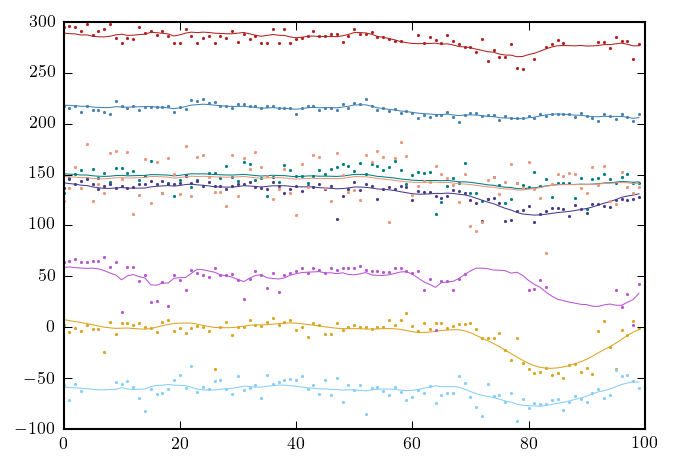

In [184]:
YHat5000 = np.dot(C5000, XHat5000)

for s, c in zip(range(N), colors):
    plt.plot(Y[s, :], '.', color=c, markersize=2)
    plt.plot(YHat5000[s, :], color=c, linewidth=0.5)

In [185]:
nLF = 3

ti = 6000
tf = 6100

Y = fullData[ti:tf, 0:fullData.shape[1]/2].T

N, T = Y.shape

XHat6000, sigma_smooth6000, A6000, C6000, Q6000, R6000, pi06000, sigma06000 = ssmEM(Y, nLF, maxIt=500)

print "A = " + str(A)
print "C = " + str(C)

A = [[  3.56382651  -5.4101772   -1.96754277]
 [  4.41471133  -8.19120422  -3.32789108]
 [ -8.66989648  18.01230391   7.51721015]]
C = [[-0.57558453  2.56059058  1.13367278]
 [-0.73073125  3.33899501  1.48423199]
 [ 0.02626702  0.03742462  0.02361679]
 [-0.31617948  1.00705392  0.41593102]
 [-0.37514337  1.72992926  0.7698112 ]
 [-0.33952774  1.62063679  0.72328779]
 [-0.36338822  1.6877249   0.75201614]
 [ 0.22872165 -0.81328655 -0.34729627]]


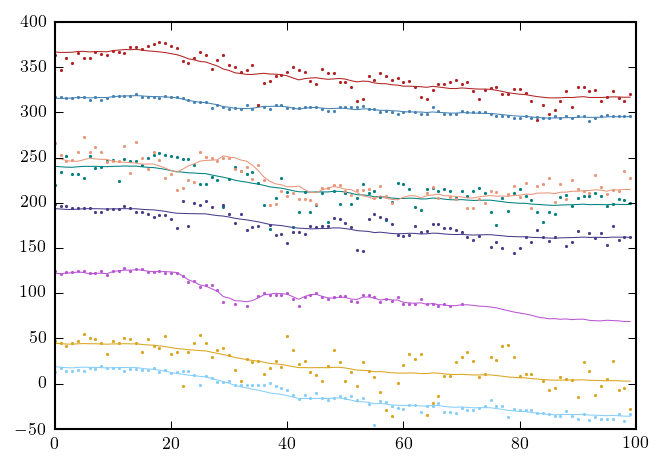

In [186]:
YHat6000 = np.dot(C6000, XHat6000)

for s, c in zip(range(N), colors):
    plt.plot(Y[s, :], '.', color=c, markersize=2)
    plt.plot(YHat6000[s, :], color=c, linewidth=0.5)

In [189]:
C5000

array([[-0.57475091,  2.55980166,  1.13367975],
       [-0.75343982,  3.37990617,  1.49865346],
       [ 0.02476291,  0.02572308,  0.01689129],
       [-0.15824867,  0.69647566,  0.30470077],
       [-0.39020584,  1.7589791 ,  0.78015277],
       [-0.3482021 ,  1.62909635,  0.72502675],
       [-0.38420461,  1.72867116,  0.76671167],
       [ 0.18140417, -0.72682707, -0.31757605]])

In [190]:
C6000

array([[ -1.84413632,   9.84231136,   4.22630652],
       [ -1.87789065,  12.35192876,   6.72431836],
       [  0.0799811 ,   0.82069803,   2.4925387 ],
       [  0.33816856,  28.06466932,  14.00212291],
       [ -1.36772743,  -0.43646749,   1.44596199],
       [ -1.18057086,  -2.53598968,   0.14247453],
       [ -2.40566675, -34.87575495, -13.04361259],
       [  0.39611979,   1.20494732,   3.43009929]])

### Plots results

In [10]:
def plotResults(Y, YHat, ylims=None):
    N, T = Y.shape
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)

    for s, c in zip(range(0, N/2), colors[0:N/2]):
        plt.plot(YHat[s, :], linewidth=0.5, color=c)
        plt.plot(Y[s, :], '.', color=c, markersize=3)
        
    plt.xlim((0, T-1))
    if ylims is not None:
        plt.ylim(ylims)
        
    plt.ylabel("Snow depth")
    plt.xlabel("Observation number")

    ######################
    
    plt.subplot(1, 2, 2)
    
    for s, c in zip(range(N/2, N), colors[N/2:N]):
        plt.plot(YHat[s, :], linewidth=0.5, color=c)
        plt.plot(Y[s, :], '.', color=c, markersize=3)
        
    plt.xlim((0, T-1))
    if ylims is not None:
        plt.ylim(ylims)
        
    #plt.ylabel("Temperature")
    plt.xlabel("Observation number")

### Run EM on other data

In [44]:
nLF = 4

ti = 13766
tf = 14066
#ti = 7750
#tf = 7850
#ti = 7850
#tf = 8000
#ti = 15800
#tf = 15900

YRaw = fullData[ti:tf, 0:fullData.shape[1]/2].T

N, T = YRaw.shape

# Align the series to improve performance
Y, cs, ci = alignSeries(YRaw)

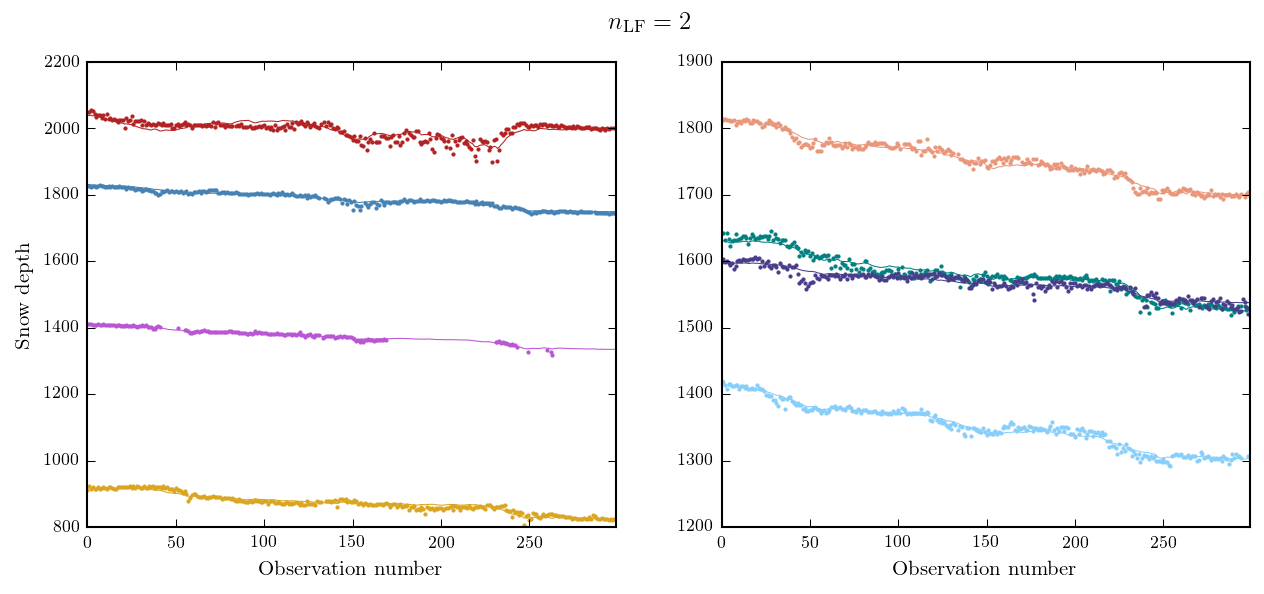

In [14]:
plotResults(YRaw, YHatDS)#, ylims=(-0.25, 0.21))
plt.suptitle(r"$n_{\rm LF} = %i$"%nLF)

### Run Kalman smoother on next part of data using the learned parameters

In [32]:
def ksAndPlot(A, C, Q, R, nLF, ti, tf, pi0Fact, XHatPrev, sigma_smoothPrev, ylims=None, fullData=fullData, ds=False):
    """
    Runs Kalman smoother with provided parameters and plots result
    """
    YRaw = fullData[ti:tf, :].T
    T = YRaw.shape[1]

    # Align the series to improve performance
    Y, cs, ci = alignSeries(YRaw)
    
    # Estimate hidden state
    XHat, sigma_smooth, _, _ = kalmanSmooth(Y, pi0Fact*XHatPrev[:, -1], pi0Fact**2 * sigma_smoothPrev[-1, :, :], A, C, Q, R, nLF)
    # Estimate observations
    YHat = np.dot(C, XHat)

    if ds:
        YHatDS = YHat.copy()
        for s in range(N):
            YHatDS[s, :] = (YHatDS[s, :] - ci[s]) / cs[s]
            
        plotResults(YRaw, YHatDS, ylims)
    else:
        plotResults(Y, YHat, ylims)

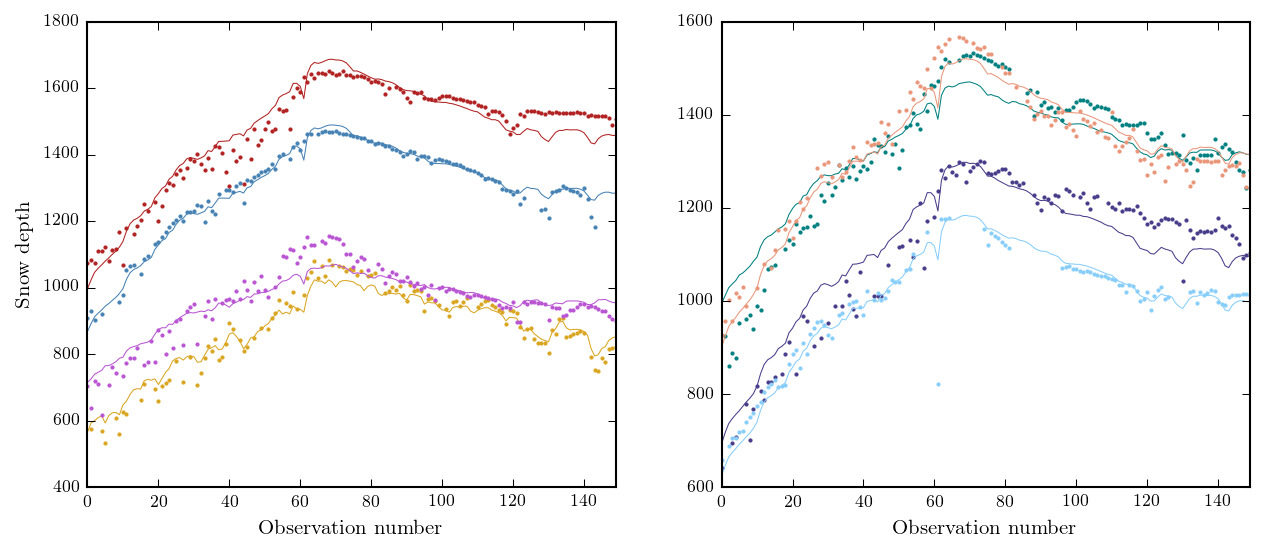

In [33]:
ksAndPlot(A, C, Q, R, nLF, ti=7850, tf=8000, pi0Fact=-0.18, XHatPrev=XHat, sigma_smoothPrev=sigma_smooth, fullData=fullData[:, 0:fullData.shape[1]/2], ds=True)

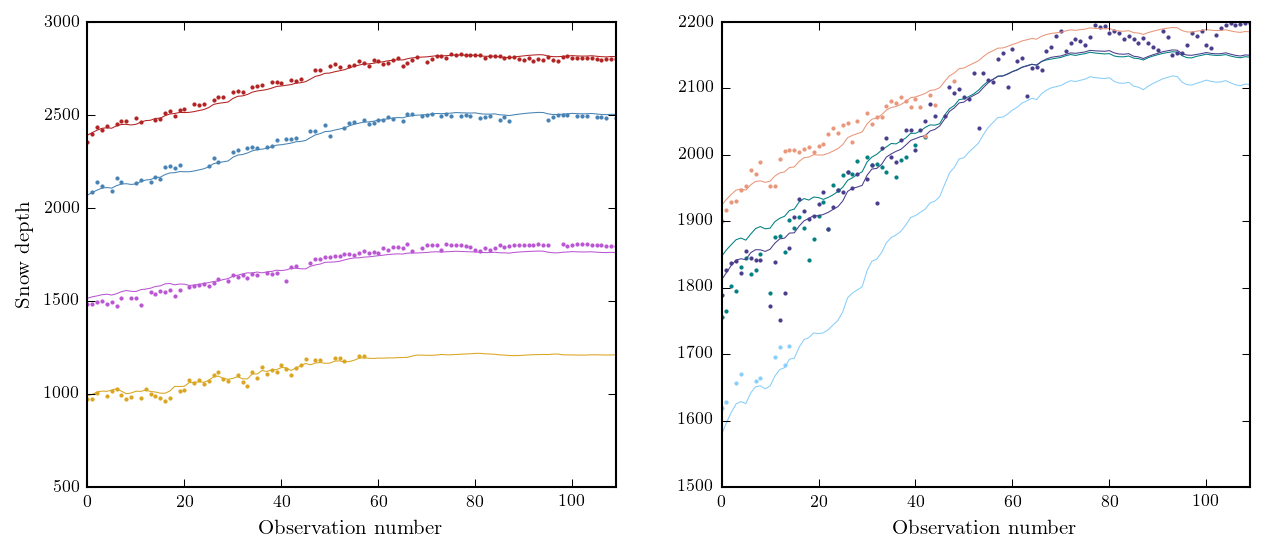

In [18]:
ksAndPlot(A, C, Q, R, nLF, ti=15790, tf=15900, pi0Fact=-0.07, XHatPrev=XHat, sigma_smoothPrev=sigma_smooth, fullData=fullData[:, 0:fullData.shape[1]/2], ds=True)

In [174]:
ti = 15790
tf = 15900
nLF = 2

YRaw = fullData[ti:tf, :].T

N, T = YRaw.shape

# Align the series to improve performance
Y, cs, ci = alignSeries(YRaw)

XHat, sigma_smooth, A, C, Q, R, pi0, sigma0 = ssmEM(Y, nLF, maxIt=300)

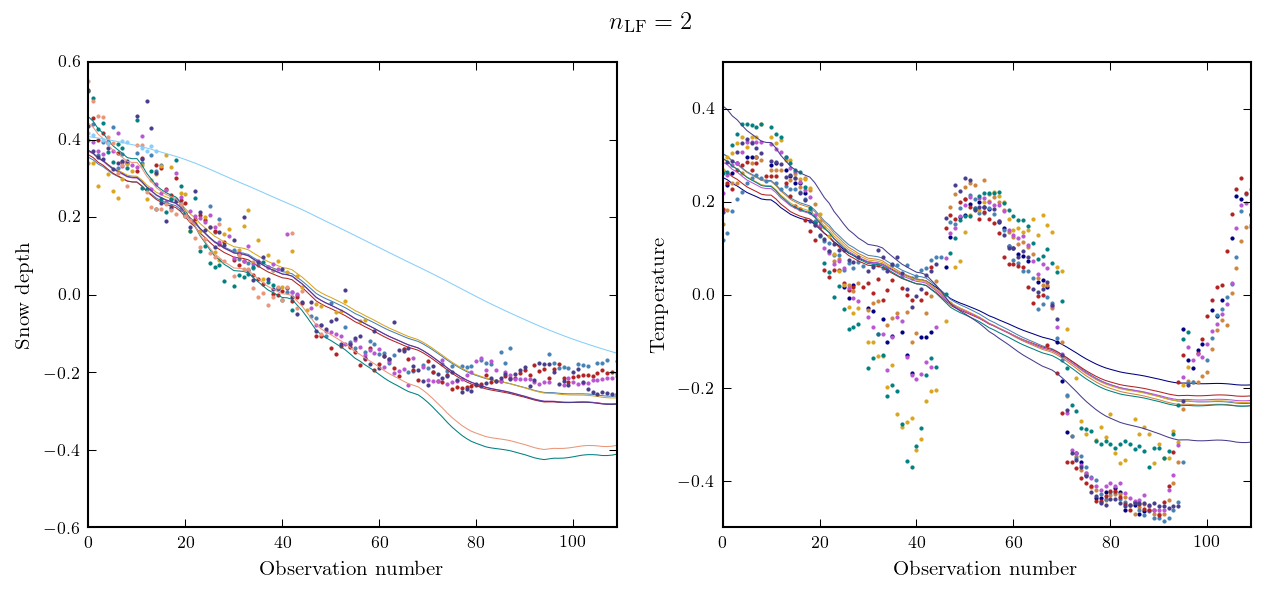

In [175]:
plotResults(Y, np.dot(C, XHat))#, ylims=(-0.25, 0.21))
plt.suptitle(r"$n_{\rm LF} = %i$"%nLF)

#### Look at the latent factors.
No obvious physical meaning...

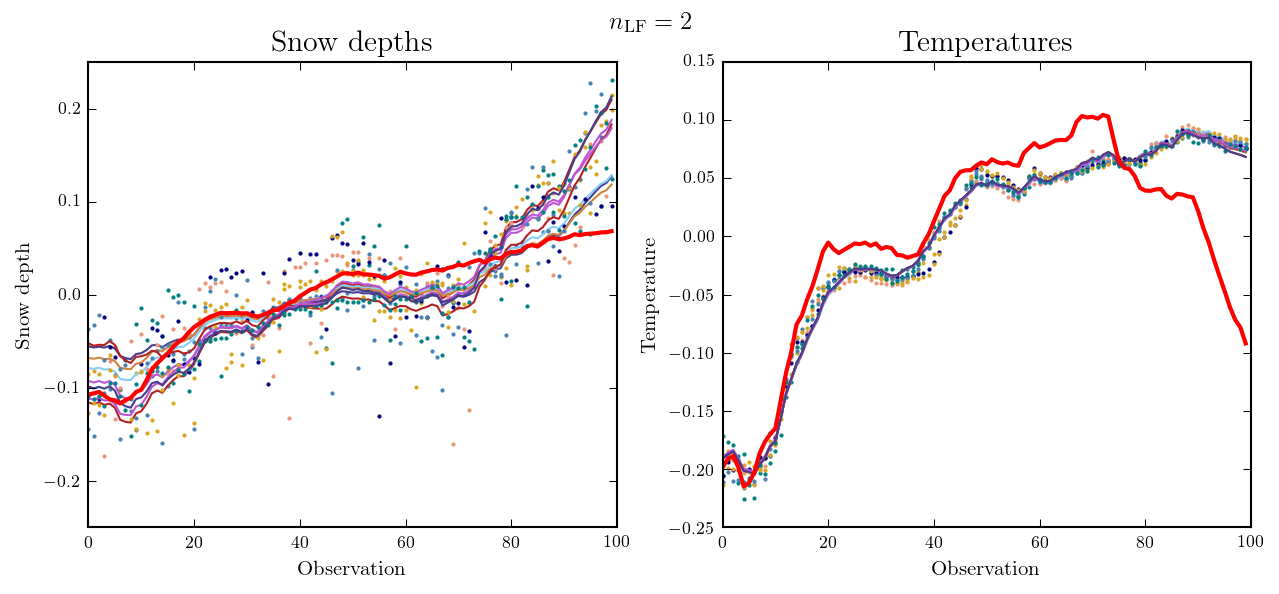

In [148]:
plt.figure(figsize=(10, 4))

lf = 1

plt.subplot(1, 2, 1)

for s in range(0, N/2):
    plt.plot(Y[s, :], '.', markersize=3)
    plt.plot(YHat[s, :])

plt.plot(-1.1*XHat[0, :], 'r', linewidth=2)
plt.ylim(-0.25, 0.25)

plt.xlabel("Observation")
plt.ylabel("Snow depth")
plt.title("Snow depths")

#########################

plt.subplot(1, 2, 2)

for s in range(N/2, N):
    plt.plot(Y[s, :], '.', markersize=3)
    plt.plot(YHat[s, :])

plt.plot(-4*XHat[lf, :], 'r', linewidth=2)
plt.ylim(-0.25, 0.15)
    
plt.xlabel("Observation")
plt.ylabel("Temperature")
plt.title("Temperatures")

plt.suptitle(r"$n_{\rm LF} = %i$"%nLF)